In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 23 days


In [21]:
import numpy as np
from matplotlib.pyplot import *
import operator

In [95]:
import matplotlib
matplotlib.rc('image', cmap='gray_r')
matplotlib.rc('axes', titlesize=24)
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')

rtitle = lambda t: matplotlib.pyplot.title(t, y=1.2)
def matshow_symm(data, *args, **kwargs):
    maxabs = np.abs(data[~np.isnan(data)]).max()
    matshow(data, *args, vmin=-maxabs, vmax=maxabs, **kwargs)

## Generate data using known autoregressive process

In [436]:
T = 10000 # number of timepoints
p = 5 # autoregressive process length

#np.random.seed(5) # set this so we get the same kernel each time
w_real = np.random.randn(p) * np.linspace(0.1, 1, p) # autoregressive weights
w_real /= 2 * np.sqrt((w_real**2).sum()) # why this normalization? it seems to keep things from diverging..
add_noise = np.random.randn(T) # noise at each timepoint
signal = np.zeros(T)
signal[:p] = add_noise[:p]

for t in range(p, T):
    signal[t] = np.dot(w_real, signal[t-p:t]) + add_noise[t]

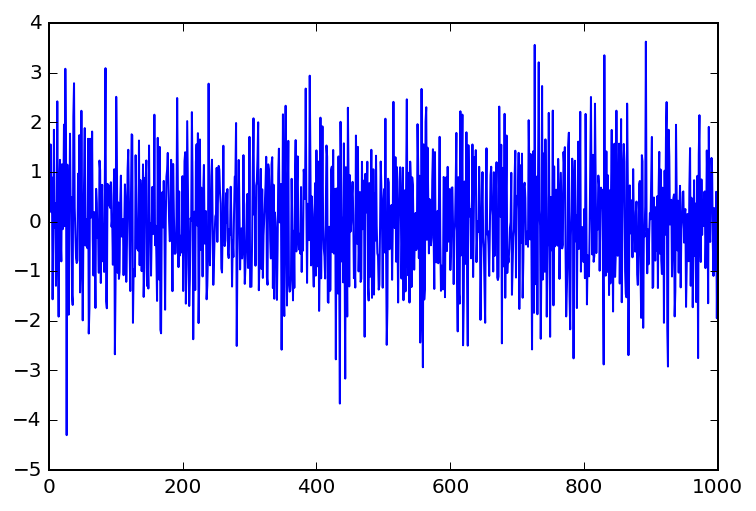

In [437]:
plot(signal[:1000])

# Estimate spectrum using standard methods (Welch's periodogram)

In [446]:
from matplotlib.mlab import psd

S_psd, f_psd = psd(signal, NFFT=256, Fs=1.0)

# Estimate spectrum using autocorrelation function

In [447]:
import scipy.signal

autocorr = scipy.signal.correlate(signal, signal) # compute autocorrelation
ks = np.arange(-T + 1, T) # lags

# Convert autocorrelation to power spectrum using Wiener-Kinchin
# formula from: https://en.wikipedia.org/wiki/Wiener%E2%80%93Khinchin_theorem#The_case_of_a_discrete-time_process
f = np.linspace(0, 0.5, 100) # frequencies up to Nyquist
S_autocorr = np.abs(reduce(operator.add, (c * np.exp(-2j * np.pi * f * k) 
                                          for c,k in zip(autocorr, ks))))

# Estimate spectrum using autoregressive AR(p) model

In [448]:
from regression_code.huth.autoreg import build_arp_model 

p_est = 10 # length of AR model. smaller = smoother spectrum estimate, larger = more detailed spectrum estimate
w_est = build_arp_model(signal, p=p_est) # compute autoregressive model using OLS

# Convert AR weights to power spectrum (re-use f from autocorrelation)
# formula from: https://en.wikipedia.org/wiki/Autoregressive_model#Spectrum
S_ar = 1 / np.abs(1 - np.array([w_est[k] * np.exp(-2j * np.pi * (k+1) * f) 
                                for k in range(p_est)]).sum(0))**2

### (Compute theoretical spectrum using actual weights $w_{real}$)

In [449]:
S_real = 1 / np.abs(1 - np.array([w_real[::-1][k] * np.exp(-2j * np.pi * (k+1) * f) 
                                  for k in range(p)]).sum(0))**2

# Plot comparison of results

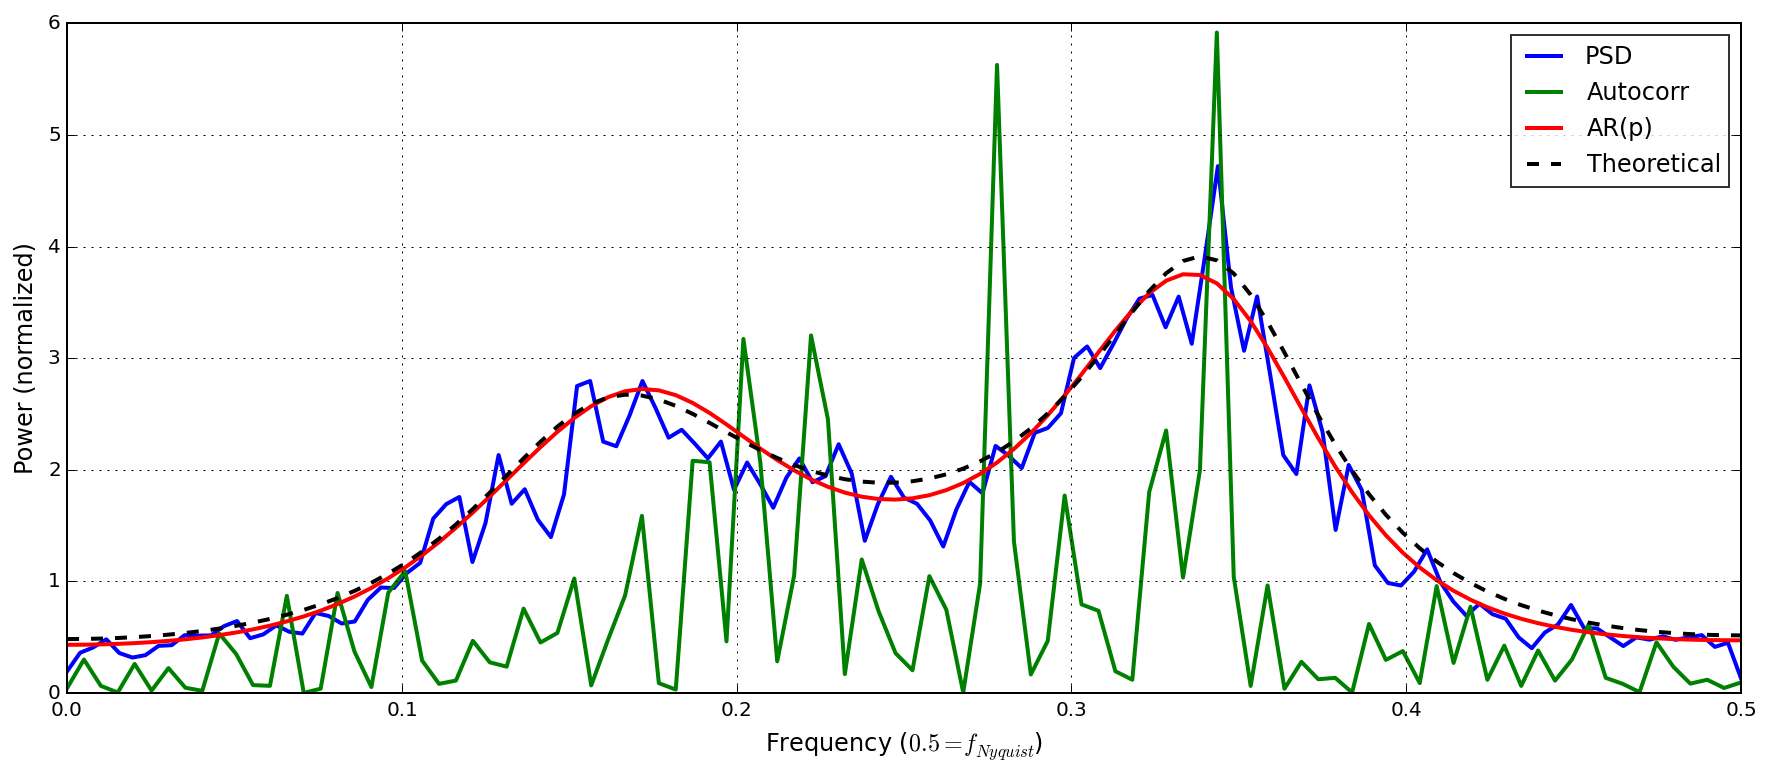

In [450]:
figure(figsize=(15,6))
norm = lambda v: v/v.std()
pargs = dict(lw=2)

plot(f_psd, norm(S_psd), label='PSD', **pargs)
plot(f, norm(S_autocorr), label='Autocorr', **pargs)
plot(f, norm(S_ar), label='AR(p)', **pargs)
plot(f, norm(S_real), '--k', label='Theoretical', **pargs)

legend(framealpha=0.8, loc='top left'); grid();
xlabel("Frequency ($0.5 = f_{Nyquist}$)", size='large')
ylabel("Power (normalized)", size='large');